# Plot Coincidence Trigger

## Import Libraries

In [1]:
import os, sys
import obspy as obs
import matplotlib.pyplot as plt

from obspy.clients.fdsn import Client
from obspy.signal.trigger import coincidence_trigger
from numpy import sort, argmin

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [15]:
config = {}

## before 2023-04-01
config['seeds'] = {"rotation":"PY.BSPF..HJ*", "translation":"II.PFO.10.BH*"}
## after 2023-04-01
# config['seeds'] = ["PY.BSPF..HJ*", "PY.PFOIX..HH*"]

config['output_path'] = data_path+"BSPF/trigger2/"

config['dir_data'] = data_path+"BSPF/data/"

config['client'] = Client("IRIS")

In [ ]:
# !ls /import/kilauea-data/BSPF/trigger/tmp

## Load Data

In [4]:
def __request_data(seed, client, tbeg, tend):

#     print(seed)
    net, sta, loc, cha = seed.split(".")

    try:
        inventory = client.get_stations(network=net, 
                                         station=sta,
                                         starttime=tbeg,
                                         endtime=tend,
                                         level="response",
                                         )
    except:
        print(f" -> Failed to load inventory for {seed}!")
        return

    try:
        waveform = client.get_waveforms(network=net,
                                       station=sta,
                                       location=loc,
                                       channel=cha, 
                                       starttime=tbeg-60,
                                       endtime=tend+60,
                                       )

    except:
        print(f" -> Failed to load waveforms for {seed}!")
        return
    
    return waveform, inventory

In [5]:
# st_xpfo, inv_xpfo = __request_data(config['seeds']['translation'], config['client'], config['tbeg'], config['tend'])

In [6]:
# st_bspf, inv_bspf = __request_data(config['seeds']['rotation'], config['client'], config['tbeg'], config['tend'])

## Load Triggered Events

In [7]:
def __read_pickle(config, path, filename):
    
    import pickle

    with open(path+filename, 'rb') as f:
        triggerfile = pickle.load(f)
        
    return triggerfile

In [8]:
trigger_events = __read_pickle(config, config['output_path'], "trigger_all.pkl")

In [23]:
times, cosum = [], []
ref_time = obs.UTCDateTime("2022-10-01")

for trig in trigger_events:
    times.append(trig['time'])
    cosum.append(trig['coincidence_sum'])
    
rel_times = [(t-ref_time)/86400 for t in times]
trigger_times = [t for t in times]

In [26]:
# __read_pickle(config, "./", "BSPF_event_catalog.pkl")

In [17]:
## read catalog
cat = obs.read_events(config['dir_data']+"events_all.xml")

print(len(cat), len(trigger_events))

4969 73


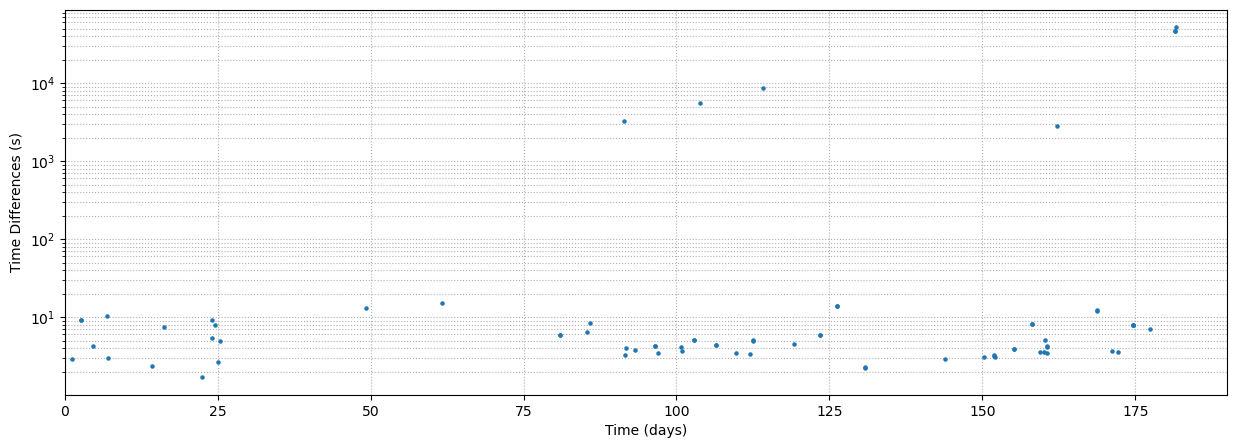

In [29]:
def __find_matches(trigger_times, catalog, max_time_difference=60):

    matches, time_diffs, events_triggered, event_idxs = [], [], [], []

    ## extract origin times from catalog
    event_times = [catalog.events[j].origins[0].time for j in range(len(catalog))]
    
    
    for trigger_time in trigger_times:

        ## compute time differences in seconds
        diff = [event_time-trigger_time for event_time in event_times]
        
        ## only the ones before the trigger in time
        abs_diff = [abs(d) for d in diff if d < 0]
        
        ## get closest event
        t_min, t_idx = min(abs_diff), diff.index(-min(abs_diff))
                
        time_diffs.append(t_min)
        matches.append(trigger_time)
        events_triggered.append(event_times[t_idx])
        event_idxs.append(t_idx)
        
    cat_sel = [cat.events[idx] for idx in event_idxs]
        
        
    t_days = [(match-obs.UTCDateTime("2022-10-01"))/86400 for match in matches]
    plt.figure(figsize=(15,5))
    plt.scatter(t_days, time_diffs, zorder=2, s=5)
    plt.yscale("log")
    plt.grid(which="both", zorder=-1, ls=":")
    plt.ylabel("Time Differences (s)")
    plt.xlabel("Time (days)")
    plt.xlim(0, 190)
    
    return np.array(matches), np.array(events_triggered), cat_sel

matches, events_triggered, cat_select = __find_matches(trigger_times, cat, max_time_difference=60)

# len(events_triggered), len(matches)

In [37]:
cata = obs.Catalog()
for ev in cat_select:
    cata += ev
cata.write(config['output_path']+"matched_catalog_events.xml", format="QUAKEML")

AttributeError: 'Catalog' object has no attribute 'magnitues'